# CSPB 3202 Final Project #

Tyler Kinkade, jaki9292@colorado.edu

GitHub: [https://github.com/jaki9292/rl-project](https://github.com/jaki9292/rl-project)

## Overview ##

This write-up reports on a small project to train and test a reinforcement learning algorithm (Russell & Norvig, 2022; Sutton & Barto, 2018) with the Gymnasium (2022) Python software package. 

This report is divided into the following sections: approach, results, discussion, and suggestions for future research.

## Approach ##

This section is divided into the following subsections: environment and game rules, models, methods and purpose, and problem solving procedure.

### Environment and Game Rules ###

Does it explain how the environment works and what the game rules are?


In [3]:
# Display Lunar Lander GIF
from IPython.display import Image
# from IPython.core.display import HTML 
Image(url= "https://gymnasium.farama.org/_images/lunar_lander.gif")

In [1]:
# Run and record random agent in lunar lander environment
# References: 
# https://gymnasium.farama.org/
# https://gymnasium.farama.org/api/utils/#save-rendering-videos
# https://gymnasium.farama.org/environments/box2d/lunar_lander/
# https://github.com/openai/gym/blob/master/gym/envs/box2d/lunar_lander.py

# Install dependencies
# pip install gymnasium
# pip install gymnasium[box2d]
# pip install moviepy

import gymnasium as gym
from gymnasium.utils.save_video import save_video
from IPython.utils.capture import capture_output

# Initialize environment
env1 = gym.make("LunarLander-v2", 
               continuous = False,          # Discrete version
               gravity = -10.0, 
               enable_wind = False, 
               wind_power = 0.0, 
               turbulence_power = 0.0, 
               render_mode="rgb_array_list") # Render for machine

# Reset environment with random number generator seed for reproducibility
observation, info = env1.reset(seed = 21)

# Accumulator variables
reward_total = 0.0
reward_totals = []
episode = 0
step_start_index = 0

# Attempt for 1000 timesteps
for step_index in range(1000):

    # Get random action from action space
    action = env1.action_space.sample()

    # Obtain observation, reward, terminated status, truncated status, 
    # and environment info for given action
    observation, reward, terminated, truncated, info = env1.step(action)

    # Accumulate reward total 
    reward_total += reward

    # If episode ends
    if terminated or truncated:
        # Append total to list of reward totals
        reward_totals.append(reward_total)

        # Report result
        print(f"Episode {episode} total rewards: {reward_total}")

        # Suppress moviepy stdout
        # https://stackoverflow.com/a/35624406/14371011
        with capture_output() as captured:
            # Save mp4 video of every (k^3)th (i.e., 0, 1, 8, 27, ...)
            save_video(env1.render(),
                    video_folder = "videos",
                    name_prefix = "random_agent",
                    fps = env1.metadata["render_fps"],
                    step_starting_index = step_start_index,
                    episode_index = episode)

        # Increment episode
        episode += 1

        # Set starting step index for videos to next step
        step_start_index = step_index + 1

        # Reset reward total
        reward_total = 0
        
        # Start new episode 
        observation, info = env1.reset()

env1.close()

Episode 0 total rewards: -87.69935868864103
Episode 1 total rewards: -284.57740568722716
Episode 2 total rewards: -393.0782931609218
Episode 3 total rewards: -121.8800194583655
Episode 4 total rewards: -116.14798955222155
Episode 5 total rewards: -107.9828222740091
Episode 6 total rewards: -427.984621698972
Episode 7 total rewards: -248.68291303125363
Episode 8 total rewards: -336.4560561761758
Episode 9 total rewards: -150.52669674540215
Episode 10 total rewards: -95.64151826512735


[Link to open video of first episode](videos/random_agent-episode-0.mp4)

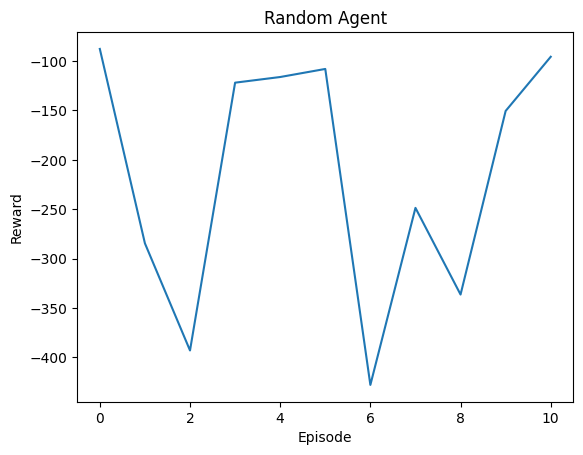

In [2]:
import matplotlib.pyplot as plt

plt.plot(reward_totals)
plt.title("Random Agent")
plt.xlabel("Episode")
plt.ylabel("Reward");

### Models ###

Does it explain clearly the model(s) of choices, the methods and purpose of tests and experiments?

Approximate reinforcement learning (Russell & Norvig, 2022; Sutton & Barto, 2018)



### Methods and Purpose ###

methods and purpose of tests and experiments





### Problem Solving Procedure ###

Does it show problem solving procedure- e.g. how the author solved and improved when an algorithm doesn't work well. Note that it's not about debugging or programming/implementation, but about when a correctly implemented algorithm wasn't enough for the problem and the author had to modify/add some features or techniques, or compare with another model, etc.

## Results ## 

show the result and interpretation of your experiment. Any iterative improvements summary.

demo clips

Does it include the results summary, interpretation of experiments and visualization (e.g. performance comparison table, graphs etc)?

## Discussion ## 

Does it include discussion (what went well or not and why), and suggestions for improvements or future work?

## Suggestions for Future Research ##




## References ##

Gymnasium. (2022). _Gymnasium documentation._ Farama Foundation. [https://gymnasium.farama.org/](https://gymnasium.farama.org/)

Russell, S., & Norvig, R. (2022). Artificial intelligence: A modern approach, (4th ed.). Pearson. 

Sutton, R. S., & Barto, A. G. (2018). Reinforcement learning: An introduction. MIT Press.